Consider the following parameterization of a policy: There is a \preference" for each
action, for each column and for each row. Thus the set of preferences can be denoted by
θx(N; 0); θy(N; 0); θx(S; 0); θy(S; 0); θx(E; 0); θy(E; 0); :::; θx(W; 9); θy(W; 9), for a total of
80 preference values. The total preference for an action a in a state (i, j) is given by
θx(a; i) + θy(a; j). The action probabilities are generated by a soft-max function using
these preferences.
4. Implement a MC policy gradient algorithm. Choose appropriate learning rates, and turn
in two curves for each variant as indicated in the first part as well as the optimal policies
learnt.

In [1]:
import gym
import gym_pdw

import numpy as np
from matplotlib import pyplot as plt

In [2]:
def softmax_action(state, parameters):
    '''
    Returns action and the probability of that action
    '''
    x, y = state
    north = parameters[x,0,0] + parameters[y,1,0]
    east = parameters[x,0,1] + parameters[y,1,1]
    west = parameters[x,0,2] + parameters[y,1,2]
    south = parameters[x,0,3] + parameters[y,1,3]
    
    # The preferences of each action
    preferences = [north, east, west, south]    
    prefs = np.exp(preferences)
    # The probability of selecting each action
    softmax = (prefs)/np.sum(prefs)
    
    action = np.random.choice([0,1,2,3], 1, p=softmax)
#     print(action)
    action = action[0]
    
    return action, softmax[action]

In [3]:
def selected_param_pos(state, action):
    '''
    Returns the row, column, the direction assigned to the parameter
    '''
    direction = action
    row,col = state
    return row, col, direction

In [4]:
def Update(parameters, states, actions, rewards, params_pos, probs, gamma, alpha):
    '''
    Updates the the parameters
    '''
    
    # Initialize return
    G = 0
    
    i=0
    for prob, pos, reward in zip(probs[::-1], params_pos[::-1], rewards[::-1]):
        
        # The positions of parameters that was used to select the action in ith time step
        row, col, direction = pos
        
        # The parameters that were used in action selection
        theta1 = parameters[row, 0, direction]
        theta2 = parameters[col, 1, direction]
                
        # The return 
        G = reward + pow(gamma,i)*G
        
        # The update equations
        theta1 = theta1 + alpha*pow(gamma,i)*(1 - prob)
        theta2 = theta2 + alpha*pow(gamma,i)*(1 - prob)
        
        parameters[row, 0, direction] = theta1
        parameters[col, 1, direction] = theta2
        
        i+=1
        
        return parameters


In [5]:
def plot_MCPG(avg_reward, steps, episodes):
    '''
    Gets the data for all curves and plots them in one graph
    '''

    
    # Figure instances will be returned.
    fig1=plt.figure(figsize=(10,6)).add_subplot(111)
    fig2=plt.figure(figsize=(10,6)).add_subplot(111)

    # colors for different values of epsilon
    colors = ['g', 'r', 'k', 'b', 'y','m', 'c']

    fig1.plot(range(episodes), avg_reward, colors[0], label = " Average reward " )
    fig2.plot(range(episodes), steps, colors[1], label = " Steps")

    # Labelling the plot
    fig1.title.set_text('Monte carlo policy gradient avg reward')
    fig1.set_ylabel('Average Reward')
    fig1.set_xlabel('episodes')
    fig1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Labelling the plot
    fig2.title.set_text('Monte carlo policy gradient num steps')
    fig2.set_ylabel('Steps')
    fig2.set_xlabel('episodes')
    fig2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Display the plot
    plt.show()

In [18]:

def MC_PG(alpha, gamma, episodes):
    '''
    Performs monte carlo policy gradient
    '''
    
    # For each row,direction and For each column,direction one parameter
    parameters = np.ones([12,2,4])
    
    # Set goal postion
    goal_pos = env.set_goal('A')

    # The num steps and avg_reward that we get from each episode is stored
    steps = np.zeros([episodes])
    avg_reward = np.zeros([episodes])
    
    for episode in range(episodes):
        # An episode
        
        # Store all the states, actions, rewards till the end of episode 
        states = []
        actions = []
        rewards = []
        
        # The parameters that are at each time step
        params_pos = []
        # The probability of picking those parameters
        probs = []
        
        # Reset environment
        env.reset()
        
        # Initialize state
        curr_state = env.get_state()
        
        
        while True:
            # For each step of an episode
            
            # select an action according to softmax probabilities
            curr_action, prob = softmax_action(curr_state, parameters)
#             print(action)

#             print("curr_action = ", curr_action,"curr_state = ",curr_state )

            # Get reward and next state
            next_state, reward = env.step(curr_state, curr_action)
            
            probs.append(prob)
            params_pos.append(selected_param_pos(curr_state, curr_action))
            
            states.append(curr_state)
            actions.append(curr_action)
            rewards.append(reward)

            # Increase the number of steps
            steps[episode] +=1
            
            # Average reward till now
            avg_reward[episode] += reward

            curr_state = next_state
#             curr_action = next_action
#             print(curr_state, "curr_state", env.start_positions)

            if curr_state == goal_pos:
                print("Goal reached!!", steps[episode])
                break
        
        # Update the parameters used in action selection in the episode
        parameters = Update(parameters, states, actions, rewards, params_pos, probs, gamma, alpha)
            
    
    return avg_reward, steps, parameters
    

Goal reached!! 23.0
Goal reached!! 252.0
Goal reached!! 57.0
Goal reached!! 58.0
Goal reached!! 65.0
Goal reached!! 24.0
Goal reached!! 35.0
Goal reached!! 62.0
Goal reached!! 31.0
Goal reached!! 26.0
Goal reached!! 45.0
Goal reached!! 43.0
Goal reached!! 79.0
Goal reached!! 28.0
Goal reached!! 62.0
Goal reached!! 50.0
Goal reached!! 21.0
Goal reached!! 43.0
Goal reached!! 52.0
Goal reached!! 31.0
Goal reached!! 27.0
Goal reached!! 35.0
Goal reached!! 54.0
Goal reached!! 41.0
Goal reached!! 25.0
Goal reached!! 29.0
Goal reached!! 96.0
Goal reached!! 52.0
Goal reached!! 57.0
Goal reached!! 38.0
Goal reached!! 43.0
Goal reached!! 42.0
Goal reached!! 30.0
Goal reached!! 48.0
Goal reached!! 13.0
Goal reached!! 34.0
Goal reached!! 48.0
Goal reached!! 30.0
Goal reached!! 40.0
Goal reached!! 32.0
Goal reached!! 52.0
Goal reached!! 71.0
Goal reached!! 62.0
Goal reached!! 62.0
Goal reached!! 32.0
Goal reached!! 59.0
Goal reached!! 39.0
Goal reached!! 51.0
Goal reached!! 76.0
Goal reached!! 46.0

Goal reached!! 69.0
Goal reached!! 46.0
Goal reached!! 46.0
Goal reached!! 42.0
Goal reached!! 34.0
Goal reached!! 51.0
Goal reached!! 35.0
Goal reached!! 51.0
Goal reached!! 47.0
Goal reached!! 52.0
Goal reached!! 26.0
Goal reached!! 26.0
Goal reached!! 21.0
Goal reached!! 49.0
Goal reached!! 31.0
Goal reached!! 40.0
Goal reached!! 39.0
Goal reached!! 19.0
Goal reached!! 38.0
Goal reached!! 35.0
Goal reached!! 32.0
Goal reached!! 24.0
Goal reached!! 32.0
Goal reached!! 39.0
Goal reached!! 31.0
Goal reached!! 26.0
Goal reached!! 34.0
Goal reached!! 56.0
Goal reached!! 32.0
Goal reached!! 55.0
Goal reached!! 47.0
Goal reached!! 37.0
Goal reached!! 51.0
Goal reached!! 24.0
Goal reached!! 60.0
Goal reached!! 21.0
Goal reached!! 20.0
Goal reached!! 23.0
Goal reached!! 61.0
Goal reached!! 21.0
Goal reached!! 43.0
Goal reached!! 58.0
Goal reached!! 47.0
Goal reached!! 41.0
Goal reached!! 46.0
Goal reached!! 25.0
Goal reached!! 58.0
Goal reached!! 16.0
Goal reached!! 47.0
Goal reached!! 23.0


Goal reached!! 45.0
Goal reached!! 29.0
Goal reached!! 30.0
Goal reached!! 41.0
Goal reached!! 36.0
Goal reached!! 57.0
Goal reached!! 46.0
Goal reached!! 46.0
Goal reached!! 40.0
Goal reached!! 25.0
Goal reached!! 21.0
Goal reached!! 50.0
Goal reached!! 35.0
Goal reached!! 33.0
Goal reached!! 15.0
Goal reached!! 45.0
Goal reached!! 49.0
Goal reached!! 27.0
Goal reached!! 32.0
Goal reached!! 28.0
Goal reached!! 49.0
Goal reached!! 29.0
Goal reached!! 24.0
Goal reached!! 57.0
Goal reached!! 17.0
Goal reached!! 21.0
Goal reached!! 51.0
Goal reached!! 33.0
Goal reached!! 25.0
Goal reached!! 64.0
Goal reached!! 44.0
Goal reached!! 59.0
Goal reached!! 50.0
Goal reached!! 34.0
Goal reached!! 29.0
Goal reached!! 31.0
Goal reached!! 39.0
Goal reached!! 29.0
Goal reached!! 27.0
Goal reached!! 46.0
Goal reached!! 14.0
Goal reached!! 20.0
Goal reached!! 42.0
Goal reached!! 25.0
Goal reached!! 35.0
Goal reached!! 40.0
Goal reached!! 44.0
Goal reached!! 21.0
Goal reached!! 46.0
Goal reached!! 24.0


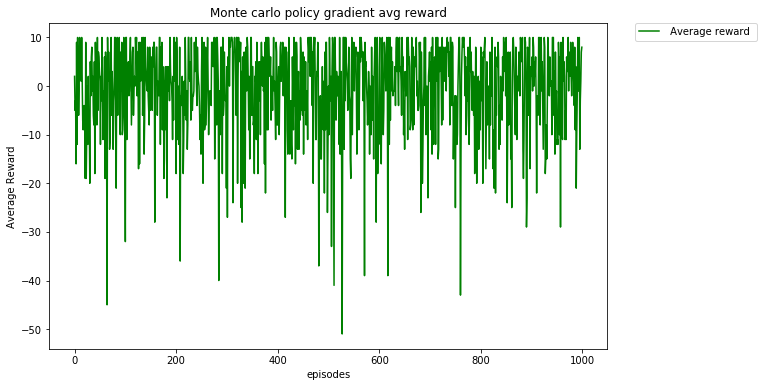

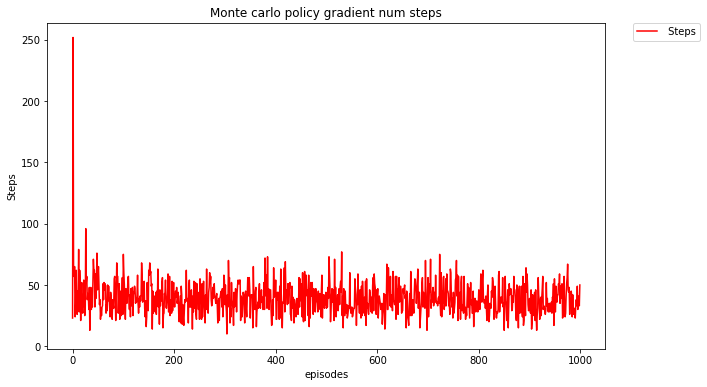

In [19]:
if __name__=='__main__':

    env = gym.make('gym_pdw:pdw-v0')
    
    # parameters
    gamma = 0.9
    alpha = 0.1
    epsilon = 0.1
    episodes = 1000
    
    avg_reward, steps, parameters = MC_PG(gamma,alpha, episodes)
    plot_MCPG(avg_reward, steps, episodes)
    

IndexError: index 2 is out of bounds for axis 1 with size 2

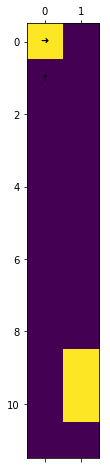

In [33]:
# To display the policy learn't
# plt.rcParams['figure.figsize'] = [8,8]
fig, ax = plt.subplots()

ax.matshow(np.argmax(parameters, axis=2))
for i in range(12):
    for j in range(12):
        c = int(np.argmax(parameters[i,j,:]))
        direcs = {0:'↑', 1:'➜', 2:'←', 3:'↓' }
        ax.text(i, j, direcs[c], va='center', ha='center')

In [16]:
z = np.zeros([12,2,4])
np.argmax(z, axis=2)

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])